In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2
from scipy.stats import poisson, nbinom, geom

from scipy.special import psi, gamma
from scipy.optimize import fsolve

### Introduction

In this Exercise, we seek a nice distribution that fits reasonably well to the count data of total number of rentals in that band (which are counts). We will use the histogram as a non parametric density estimador, then we will explore the use of the Poisson and Negative Binomial Distributions.

Data from: https://www.kaggle.com/datasets/joanpau/bike-rentals-study-uci

In [2]:
# Read data
df_0 = pd.read_csv(r'C:\Users\luis9\OneDrive\Datos\archive\train.csv')
df_c = df_0[['count']]
n_total = df_c.shape[0]

print('Sample size: ' + str(n_total))

Sample size: 10886


We will assume a Poisson distribution, that is, $X_i \sim Poisson(\lambda)$, where the parameter is $\lambda > 0$. Under indepent random sampling we know that the likelihood is
$$L(\lambda; x) = \prod_{i}^{n} \propto \lambda^{\sum_{i=1}^{n} x_i}e^{-n\lambda} = \lambda^{T(x)}e^{-n\lambda},$$
where $T(x) =\sum_{i=1}^{n} x_i$ is the sufficient statistic.

To find the máximum likelihood estimator (mle) for $\lambda$ we find the value of $\lambda > 0$ that maximizes the likelihood. But we use the loglikelihood since it's simpler:
$$l(\lambda; x) =  \ln\left( \lambda^{T(x)}e^{-n\lambda} \right) = T(x) \ln(\lambda) - n\lambda,$$
using calculos, we find the critical point
$$ \frac{dl(\lambda)}{d \lambda} =  \frac{T(x)}{\lambda} - n = 0,$$
which when we solve for $\lambda$ gives us the mle
$$ \hat{\lambda} = \frac{T(x)}{n} = \bar{x},$$
which happens to be the sample mean for the count data. This can be verified to be a maximum through the second derivative test.

Now, let us find the mle:

In [3]:
T = df_c.sum().values[0]
n = df_c.shape[0]

lambda_hat = T/n

print(r'The estimated Poisson parameter is ' + str(round(lambda_hat, 3)))

The estimated Poisson parameter is 191.574


Therefore, $\hat{\lambda} = 190.459$.

In [4]:
df_c.mean()

count    191.574132
dtype: float64

Now, let us plot the histogram for count data and the Poisson density (or mass function) with $\lambda = \hat{\lambda}$. 

Text(0.5, 1.0, 'Histogram vs. Poisson Model')

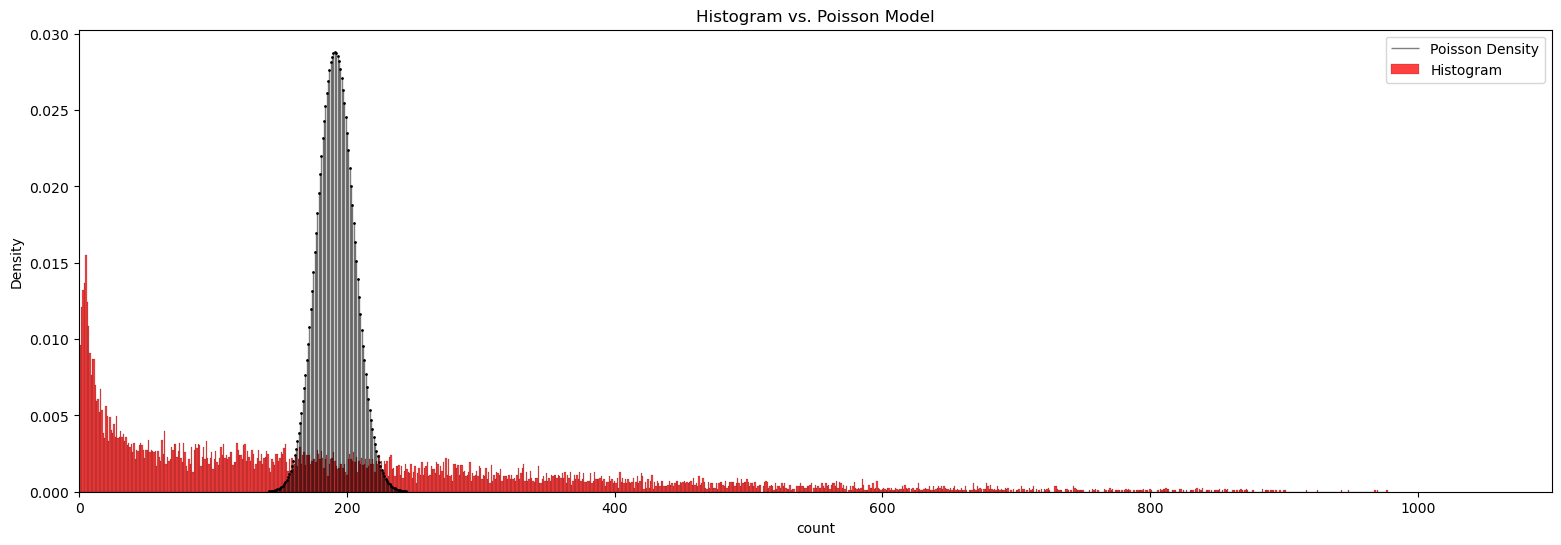

In [5]:
x = np.arange(poisson.ppf(0.0001, lambda_hat), poisson.ppf(0.9999, lambda_hat))

fig, ax = plt.subplots(1, 1, figsize=(19,6))

sns.histplot(data     = df_c,
             x        = "count",
             discrete = True, 
             stat     = 'density',
             color    = 'red',
             label    = 'Histogram',
             ax=ax)

ax.plot(x, poisson.pmf(x, lambda_hat), 'ko', ms=1)
ax.vlines(x, 0, poisson.pmf(x, lambda_hat), colors='k', lw=1, alpha=0.5,
          label='Poisson Density')

ax.set_xlim(0,1100)

ax.legend()

ax.set_title('Histogram vs. Poisson Model')

We can notice a lack of 'good' fit. Since there is a very noticeable difference between the estimated density by the histogram which doesn't impose a specific family of distributions. Also, theory tells us that the mean should be, approximately, equal to the variance under a Poisson model, but these values for the sample are too far appart.

In [6]:
df_c.mean()

count    191.574132
dtype: float64

In [7]:
df_c.var()

count    32813.313153
dtype: float64

The Poisson model seems to be a misspecification. Now, we consider the Negative Binomial distribution, that is we, assume a density 
$${\displaystyle f(x) = {x+r-1 \choose x}\cdot (1-p)^{x}p^{r},}$$
for $x = 0,1,2\ldots$. In this case, the parameters are $r > 0$ and $p \in (0,1)$.
Now, the log-likelihood is 
$${\displaystyle \ell (r,p)=\sum _{i=1}^{n}\ln(\Gamma (x_{i}+r))-\sum _{i=1}^{n}\ln(x_{i}!)-N\ln(\Gamma (r))+\sum _{i=1}^{n}x_{i}\ln(1-p)+Nr\ln(p)},$$
where $\Gamma$ is the gamma function.

To find the mle, we use calculus to find that
$$   {\displaystyle {\frac {\partial \ell (r,p)}{\partial p}}=-\left[\sum _{i=1}^{N}k_{i}{\frac {1}{1-p}}\right]+Nr{\frac {1}{p}}=0}$$
and
$${\displaystyle {\frac {\partial \ell (r,p)}{\partial r}}=\left[\sum _{i=1}^{N}\psi (k_{i}+r)\right]-N\psi (r)+N\ln(p)=0},$$
where $\psi$ is the digamma function. When we solve the first equation for $p$ we get
$${\displaystyle p={\frac {Nr}{Nr+\sum _{i=1}^{N}k_{i}}}},$$
and by substituting into the second equation we get that
$${\displaystyle {\frac {\partial \ell (r,p)}{\partial r}}=\left[\sum _{i=1}^{N}\psi (k_{i}+r)\right]-N\psi (r)+N\ln \left({\frac {r}{r+\sum _{i=1}^{N}k_{i}/N}}\right)=0}.$$
That is, the solution for $r$ is obtained numerically and gives us a $\hat{r}$:

In [8]:
def Score_r_BN(r):
    N    = df_c.values.flatten().shape[0]
    pt_1 = psi(df_c.values.flatten() + r).sum()
    pt_2 = -N*psi(r)
    pt_3 = n*np.log( r / (r + df_c.values.flatten().sum()/N))
    Score_r =  pt_1 + pt_2 + pt_3
    return(Score_r)

In [9]:
r_hat = fsolve(Score_r_BN, 1)
r_hat

array([0.85093754])

(-1000.0, 50000.0)

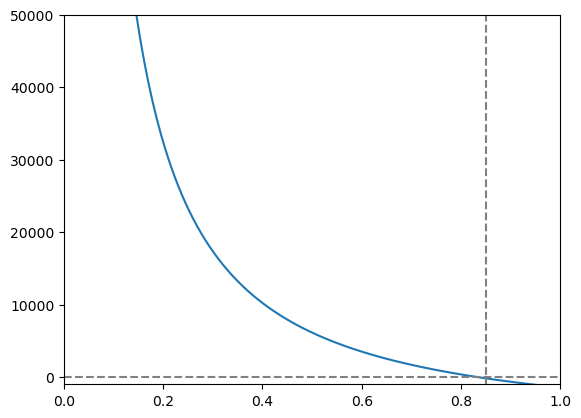

In [10]:
r_array = np.linspace(0.1, 1, n)

plt.plot(r_array, Score_r_BN(r_array))

plt.hlines(0, 0, 1, linestyle='--', color='grey')
plt.vlines(r_hat, -10000, 80000, linestyle='--', color='grey')

plt.xlim(0, 1)
plt.ylim(-1000, 50000)

In [11]:
p_hat = n*r_hat / (n*r_hat + df_c.values.flatten().sum())
p_hat

array([0.00442218])

Text(0.5, 1.0, 'Histogram vs. Negative Binomial Model')

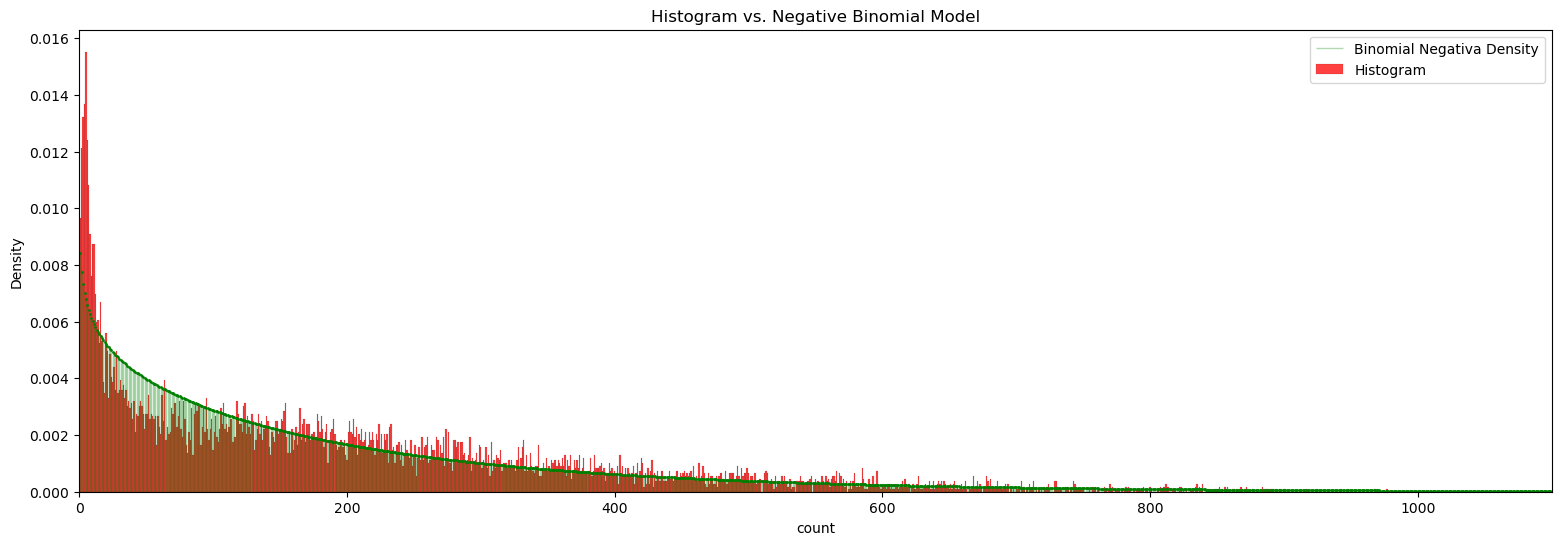

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(19,6))

y = np.arange(nbinom.ppf(0.01, r_hat, p_hat), nbinom.ppf(0.999, r_hat, p_hat))

ax.plot(y, nbinom.pmf(y, r_hat, p_hat), 'go', ms=1)

ax.vlines(y, 0, nbinom.pmf(y, r_hat, p_hat), colors='g', lw=1, alpha=0.3,
          label='Binomial Negativa Density')

sns.histplot(data     = df_c,
             x        = "count",
             discrete = True,
             stat     = 'density',
             color    = 'red',
             label    = 'Histogram',
             ax=ax)
    
ax.set_xlim(0,1100)

ax.legend()
ax.set_title('Histogram vs. Negative Binomial Model')


In [13]:
nbinom.stats(r_hat, p_hat, moments='mvsk')

(array([191.57413191]),
 array([43321.23579847]),
 array([2.16811454]),
 array([7.05106943]))

In [14]:
df_c.mean()

count    191.574132
dtype: float64

In [15]:
df_c.var()

count    32813.313153
dtype: float64

We can see that the Negative Binomial distribution gives us a better fit than the Poisson distribution when fitted to the count data of total number of rentals. This will be of use when we discuss the regression models for counts.